In [1]:
import re
import html
import pandas as pd

This notebook processes the moral annotations dataset by unifying performing EDA and unifying annotations based on confidence levels and annotator agreement.
The original dataset contains multiple annotations per text, and this notebook consolidates them into a single annotation per text creating dataset for multi-class classification.

## Load data

In [2]:
df = pd.read_csv("hf://datasets/USC-MOLA-Lab/MFRC/final_mfrc_data.csv")
df["annotation"] = df["annotation"].apply(lambda x: x.split(","))
df = df.explode("annotation", ignore_index=True).dropna(subset=["confidence"])
df.head()

,text,subreddit,bucket,annotator,annotation,confidence
0,That particular part of the debate is especial...,europe,French politics,annotator03,Non-Moral,Confident
1,That particular part of the debate is especial...,europe,French politics,annotator01,Purity,Confident
2,That particular part of the debate is especial...,europe,French politics,annotator02,Thin Morality,Confident
3,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator03,Non-Moral,Confident
4,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator00,Non-Moral,Somewhat Confident


## Clean text

In [3]:
def remove_links(text: str) -> str:
    markdown_link_pattern = r"\[([^\]]+)\]\((http[s]?://[^\)]+)\)"
    return re.sub(markdown_link_pattern, r"\1", text)


def remove_user_mentions(text: str) -> str:
    """Remove Reddit or Twitter-like mentions (u/username, @username)."""
    return re.sub(r"(u/|@)\w+", "", text)


def remove_subreddit_mentions(text: str) -> str:
    """Remove subreddit mentions (r/subreddit)."""
    return re.sub(r"r/\w+", "", text)


def remove_emojis(text: str) -> str:
    """Remove emojis and pictographs."""
    emoji_pattern = re.compile(
        "["
        "\U0001f600-\U0001f64f"  # emoticons
        "\U0001f300-\U0001f5ff"  # symbols & pictographs
        "\U0001f680-\U0001f6ff"  # transport & map symbols
        "\U0001f1e0-\U0001f1ff"  # flags
        "\U00002700-\U000027bf"  # dingbats
        "\U000024c2-\U0001f251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub("", text)


def remove_special_characters(text: str) -> str:
    """Remove non-alphanumeric characters (except basic punctuation)."""
    return re.sub(r"[^a-zA-Z0-9.,!?'\s]", "", text)


def normalize_whitespace(text: str) -> str:
    """Collapse multiple spaces/newlines into single spaces."""
    return re.sub(r"\s+", " ", text).strip()


def decode_html_entities(text: str) -> str:
    """Convert HTML entities like &amp; to &."""
    return html.unescape(text)


def clean_reddit_text(text: str) -> str:
    """Master cleaning function that applies all steps in order."""
    text = decode_html_entities(text)
    text = remove_links(text)
    text = remove_user_mentions(text)
    text = remove_subreddit_mentions(text)
    text = remove_emojis(text)
    text = remove_special_characters(text)
    text = normalize_whitespace(text)
    return text

In [4]:
df["cleaned_text"] = df["text"].apply(clean_reddit_text)
df[["text", "cleaned_text"]].head()

,text,cleaned_text
0,That particular part of the debate is especial...,That particular part of the debate is especial...
1,That particular part of the debate is especial...,That particular part of the debate is especial...
2,That particular part of the debate is especial...,That particular part of the debate is especial...
3,"/r/france is pretty lively, with it's own ling...","is pretty lively, with it's own lingo that is ..."
4,"/r/france is pretty lively, with it's own ling...","is pretty lively, with it's own lingo that is ..."


## EDA

There are 8 labels in the dataset, 6 morals and two labels for texts without or thin moral indication. The last two are the most popular labels in the dataset. The less popular moral is Care.

In [5]:
labels_freq = df.groupby("annotation").size().sort_values().index.tolist()
df.groupby("annotation").size().sort_values()

annotation
Purity              2167
Loyalty             2790
Proportionality     4583
Authority           4801
Equality            5095
Care                7749
Thin Morality      11113
Non-Moral          30762
dtype: int64

There are 3 three confidence levels.

In [6]:
df.groupby(["annotator", "confidence"])[["confidence"]].size()

annotator    confidence        
annotator00  Confident              2271
             Not Confident          6843
             Somewhat Confident     3366
annotator01  Confident             10797
             Not Confident           461
             Somewhat Confident     1693
annotator02  Confident             11405
             Not Confident           181
             Somewhat Confident     1015
annotator03  Confident             10185
             Not Confident           391
             Somewhat Confident     1617
annotator04  Confident             15778
             Not Confident            26
             Somewhat Confident     1391
annotator05  Confident               962
             Not Confident           112
             Somewhat Confident      566
dtype: int64

### Confidence scores per moral.

Annotators were less confident at scoring Authority and Thin Morality labels.

In [7]:
df.groupby(["annotation", "confidence"])[["confidence"]].size().to_frame().pivot_table(
    index="annotation", columns="confidence", values=0, fill_value=0
).apply(lambda row: row / row.sum(), axis=1).round(2)

confidence,Confident,Not Confident,Somewhat Confident
annotation,,,
Authority,0.61,0.22,0.18
Care,0.76,0.10,0.14
Equality,0.78,0.09,0.12
Loyalty,0.70,0.11,0.20
Non-Moral,0.79,0.09,0.13
Proportionality,0.76,0.09,0.15
Purity,0.77,0.09,0.14
Thin Morality,0.66,0.19,0.15


### Number of annotation per text

Most of the texts have more than one label assigned.

<Axes: ylabel='Frequency'>

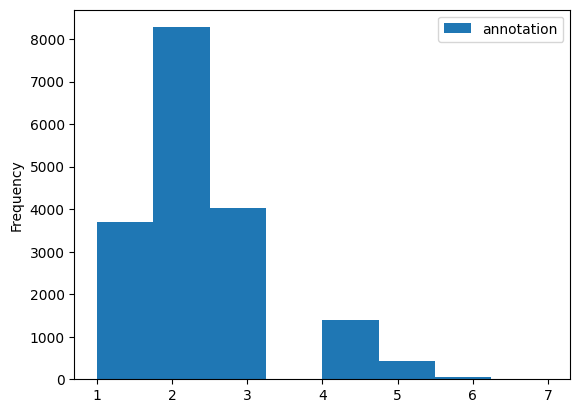

In [8]:
df.groupby(["cleaned_text"])[["annotation"]].nunique().sort_values(
    "annotation", ascending=False
).plot.hist(bins=8)

## Unifying annotations

In [9]:
def unify_annotation(
    annots: list[str], confs: list[str], labels_freq: list[str]
) -> str:
    """
    Unify multiple annotations into a single annotation based on confidence levels and frequency of labels in the dataset.

    :param annots: List of annotations.
    :param confs: List of confidence levels corresponding to the annotations.
    :param labels_freq: List of labels sorted by their frequency in the dataset (least frequent first).
    :return: A single unified annotation.
    """
    # the same annotations
    if len(set(annots)) == 1:
        return annots[0]
    annots_without_non_confident = [
        annots[i] for i in range(len(annots)) if confs[i] != "Not Confident"
    ]
    confs_without_non_confident = [
        confs[i] for i in range(len(annots)) if confs[i] != "Not Confident"
    ]
    # the same annotations after removing non confident annotations
    if len(set(annots_without_non_confident)) == 1:
        return annots_without_non_confident[0]
    # if there  are only Non-moral and thin moral return Non moral
    if set(annots_without_non_confident) == {"Non-Moral", "Thin Morality"}:
        return "Non-Moral"
    # if there are only one of moralities and thin or non morality return morality
    if len(set(annots_without_non_confident)) == 2:
        if set(annots_without_non_confident).intersection(
            {"Thin Morality", "Non-Moral"}
        ):
            return list(
                set(annots_without_non_confident) - {"Thin Morality", "Non-Moral"}
            )[0]
        # if one is confident and other somewhat confident return the confident one
        if (
            "Confident" in confs_without_non_confident
            and "Somewhat Confident" in confs_without_non_confident
        ):
            return annots_without_non_confident[
                confs_without_non_confident.index("Confident")
            ]
    # if there is a majority of one annotation return it
    if len(set(annots_without_non_confident)) > 1:
        counts = {
            annot: annots_without_non_confident.count(annot)
            for annot in set(annots_without_non_confident)
        }
        max_count = max(counts.values())
        if list(counts.values()).count(max_count) == 1:
            return max(counts, key=counts.get)
    # return the less frequent annotation in the dataset
    for label in labels_freq:
        if label in annots_without_non_confident:
            return label
    return "None"

In [10]:
df_by_text = (
    df.groupby(["cleaned_text"])[["annotation", "confidence"]]
    .agg(list)
    .reset_index()
    .rename(columns={"cleaned_text": "text"})
)
df_by_text["unified_annotation"] = df_by_text.apply(
    lambda row: unify_annotation(row["annotation"], row["confidence"], labels_freq),
    axis=1,
)
df_by_text["unified_annotation"].value_counts()

unified_annotation
Non-Moral          8703
Care               2130
Proportionality    1728
Authority          1509
Equality           1233
Loyalty            1048
Purity              955
Thin Morality       567
None                 11
Name: count, dtype: int64

## Save dataset

In [13]:
df_by_text.query("unified_annotation != 'None'").sample(frac=1, random_state=42).to_csv(
    "dataset.csv", index=False
)